# PyTorch로 시작하는 딥러닝 입문
## 4. 소프트맥스 회귀
### 원-핫 인코딩
정수 인코딩과 달리 원-핫 인코딩은 분류 문제 모든 클래스 간의 관계를 균등하게 분배함  
하지만, 단어의 유사성을 구할 수 없다는 단점이 존재 함  

### 소프트맥스 회귀의 비용 함수 구현하기

In [ ]:
import torch
import torch.nn.functional as F

torch.manual_seed(1)

#### 파이토치로 소프트맥스의 비용 함수 구현하기 (로우-레벨)

In [ ]:

z = torch.FloatTensor([1, 2, 3])

In [ ]:
hypothesis = F.softmax(z, dim=0)
print(hypothesis)

tensor([0.0900, 0.2447, 0.6652])


In [ ]:
hypothesis.sum()

tensor(1.)

In [ ]:
z = torch.rand(3, 5, requires_grad=True)
z, z.shape

(tensor([[0.7576, 0.2793, 0.4031, 0.7347, 0.0293],
         [0.7999, 0.3971, 0.7544, 0.5695, 0.4388],
         [0.6387, 0.5247, 0.6826, 0.3051, 0.4635]], requires_grad=True),
 torch.Size([3, 5]))

In [ ]:
hypothesis = F.softmax(z, dim=1) # 각 샘플에 대해 softmax 함수 적용
print(hypothesis)

tensor([[0.2645, 0.1639, 0.1855, 0.2585, 0.1277],
        [0.2430, 0.1624, 0.2322, 0.1930, 0.1694],
        [0.2226, 0.1986, 0.2326, 0.1594, 0.1868]], grad_fn=<SoftmaxBackward>)


In [ ]:
y = torch.randint(5, (3,)).long()
print(y)

tensor([0, 2, 1])


In [ ]:
y_one_hot = torch.zeros_like(hypothesis)
y_one_hot.scatter_(1, y.unsqueeze(1), 1) # scatter_(dim, index, src), 첫 번째 차원에 index 값에 1을 추가, '_' 덮어 쓰기

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])

In [ ]:
print(y.unsqueeze(1))

tensor([[0],
        [2],
        [1]])


In [ ]:
print(y_one_hot)

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])


In [ ]:
cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()

#### 파이토치로 소프트맥스의 비용 함수 구현하기 (하이-레벨)

In [ ]:
# F.softmax() + torch.log() = F.log_softmax()
# Low level
torch.log(F.softmax(z, dim=1)) 

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]], grad_fn=<LogBackward>)

In [ ]:
# High level
F.log_softmax(z, dim=1) 

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]],
       grad_fn=<LogSoftmaxBackward>)

In [ ]:
# F.log_softmax() + F.nll_loss() = F.cross_entropy()
# Low level
(y_one_hot * -torch.log(F.softmax(z, dim=1))).sum(dim=1).mean()

tensor(1.4689, grad_fn=<MeanBackward0>)

In [ ]:
(y_one_hot * - F.log_softmax(z, dim=1)).sum(dim=1).mean()

tensor(1.4689, grad_fn=<MeanBackward0>)

In [ ]:
# High level
F.nll_loss(F.log_softmax(z, dim=1), y) # nll : Negative Log likelihood

tensor(1.4689, grad_fn=<NllLossBackward>)

In [ ]:
F.cross_entropy(z, y) # F.cross_entropy()는 F.log_softmax()와 F.nll_loss()를 포함

tensor(1.4689, grad_fn=<NllLossBackward>)

### 소프트맥스 회귀 구현하기

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]

x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

#### 소프트맥스 회귀 구현하기(로우-레벨)

In [ ]:
print(x_train.shape)
print(y_train.shape)

torch.Size([8, 4])
torch.Size([8])


In [ ]:
y_train.unique()

tensor([0, 1, 2])

In [ ]:
y_one_hot = torch.zeros(8, 3) # 클래스의 개수가 [0, 1, 2] 3개
y_one_hot.scatter_(1, y_train.unsqueeze(1), 1)
print(y_one_hot.shape)

torch.Size([8, 3])


In [ ]:
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

optimizer = optim.SGD([W, b], lr=0.1)

In [ ]:
nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    hypothesis = F.softmax(x_train.matmul(W) + b, dim=1) 

    cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.761050
Epoch  200/1000 Cost: 0.689991
Epoch  300/1000 Cost: 0.643229
Epoch  400/1000 Cost: 0.604117
Epoch  500/1000 Cost: 0.568255
Epoch  600/1000 Cost: 0.533922
Epoch  700/1000 Cost: 0.500291
Epoch  800/1000 Cost: 0.466908
Epoch  900/1000 Cost: 0.433507
Epoch 1000/1000 Cost: 0.399962


#### 소프트맥스 회귀 구현하기(하이-레벨)

In [ ]:
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

optimizer = optim.SGD([W, b], lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    z = x_train.matmul(W) + b
    cost = F.cross_entropy(z, y_train)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.761050
Epoch  200/1000 Cost: 0.689991
Epoch  300/1000 Cost: 0.643229
Epoch  400/1000 Cost: 0.604117
Epoch  500/1000 Cost: 0.568256
Epoch  600/1000 Cost: 0.533922
Epoch  700/1000 Cost: 0.500291
Epoch  800/1000 Cost: 0.466908
Epoch  900/1000 Cost: 0.433507
Epoch 1000/1000 Cost: 0.399962


#### 소프트맥스 회귀 nn.Module로 구현하기

In [ ]:
model = nn.Linear(4, 3)

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    prediction = model(x_train)

    cost = F.cross_entropy(prediction, y_train)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 2.637636
Epoch  100/1000 Cost: 0.647903
Epoch  200/1000 Cost: 0.564643
Epoch  300/1000 Cost: 0.511043
Epoch  400/1000 Cost: 0.467249
Epoch  500/1000 Cost: 0.428281
Epoch  600/1000 Cost: 0.391924
Epoch  700/1000 Cost: 0.356742
Epoch  800/1000 Cost: 0.321577
Epoch  900/1000 Cost: 0.285617
Epoch 1000/1000 Cost: 0.250818


#### 소프트맥스 회귀 클래스로 구현하기

In [ ]:
class SoftmaxClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4, 3)

    def forward(self, x):
        return self.linear(x)

In [ ]:
model = SoftmaxClassifierModel()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    prediction = model(x_train)

    cost = F.cross_entropy(prediction, y_train)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.366217
Epoch  100/1000 Cost: 0.722726
Epoch  200/1000 Cost: 0.637564
Epoch  300/1000 Cost: 0.578576
Epoch  400/1000 Cost: 0.527363
Epoch  500/1000 Cost: 0.479315
Epoch  600/1000 Cost: 0.432700
Epoch  700/1000 Cost: 0.386693
Epoch  800/1000 Cost: 0.340930
Epoch  900/1000 Cost: 0.295757
Epoch 1000/1000 Cost: 0.255350


### 소프트맥스 회귀로 MNIST 데이터 분류하기

#### MNIST 데이터 이해하기
MNIST는 숫자 0부터 9까지의 이미지로 구성된 손글씨 데이터셋

#### 토치비전 소개하기
torchvision은 유명한 데이터셋들, 이미 구현되어져 있는 유명한 모델들, 일반적인 이미지 전처리 도구들을 포함하고 있는 패키지

#### 분류기 구현을 위한 사전 설정


In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [ ]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


In [ ]:
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [ ]:
training_epochs = 15
batch_size = 100

#### MNIST 분류기 구현하기

In [ ]:
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw




Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
data_loader = DataLoader(dataset=mnist_train,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

DataLoader : 로드할 대상  
batch_size : 배치 크기  
shuffle : 매 에포크마다 미니 배치를 셔플할 것인지의 여부  
drop_last : 마지막 배치를 버릴 것인지를 의미
> 다른 미니 배치보다 개수가 적은 마지막 배치를 경사 하강법에 사용하여 마지막 배치가 상대적으로 과대 평가되는 현상을 막아 줌

In [7]:
linear = nn.Linear(784, 10, bias=True).to(device) # to() 함수는 모델의 매개변수를 지정한 장치의 메모리로 보냄, CPU에선 설정할 필요 없음

In [8]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

In [9]:
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.534912407
Epoch: 0002 cost = 0.359308600
Epoch: 0003 cost = 0.331088185
Epoch: 0004 cost = 0.316574186
Epoch: 0005 cost = 0.307130307
Epoch: 0006 cost = 0.300207853
Epoch: 0007 cost = 0.294897288
Epoch: 0008 cost = 0.290830463
Epoch: 0009 cost = 0.287419587
Epoch: 0010 cost = 0.284589112
Epoch: 0011 cost = 0.281816244
Epoch: 0012 cost = 0.279919684
Epoch: 0013 cost = 0.277836859
Epoch: 0014 cost = 0.276022315
Epoch: 0015 cost = 0.274443179
Learning finished


Accuracy: 0.8867999911308289
Label:  8
Prediction:  3


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


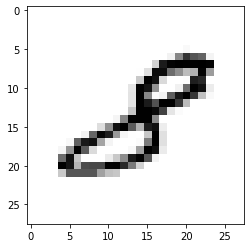

In [11]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()